In [65]:
import os
import glob
import pandas as pd
from tqdm import tqdm
import boto3
from io import BytesIO
from io import StringIO
from sklearn.ensemble import HistGradientBoostingClassifier 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle 

In [66]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [67]:
# Initialize S3 client
s3 = boto3.client('s3')

# Function to load data 
bucket_name = 'ml-stack-759578648427-us-west-2'

def from_s3(bucket_name, file_name):
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    ext = os.path.splitext(file_name)[1]
    if ext == '.gz':
        data = pd.read_csv(BytesIO(response['Body'].read()), compression='gzip')
    elif ext == '.csv':
        data = pd.read_csv(BytesIO(response['Body'].read()))
    else:
        data = pd.read_excel(BytesIO(response['Body'].read()), sheet_name='DX_to_CCSR_Mapping', header=1)
    return data

# Import Data 

In [68]:
file_name = 'MIMIC/Modeling/baseline_results.csv'
baseline_results = from_s3(bucket_name, file_name) 
baseline_results.head()

,bacteria,antibiotic,accuracy,precision,recall,f1_score
0,ESCHERICHIA COLI,AMPICILLIN,0.503929,0.503929,1.0,0.670150
1,ESCHERICHIA COLI,AMPICILLIN/SULBACTAM,0.611413,0.611413,1.0,0.758853
2,ESCHERICHIA COLI,CEFAZOLIN,0.805609,0.805609,1.0,0.892341
3,ESCHERICHIA COLI,CEFEPIME,0.915470,0.915470,1.0,0.955870
4,ESCHERICHIA COLI,CEFTAZIDIME,0.921242,0.921242,1.0,0.959007


In [83]:
file_name = 'MIMIC/Cleaned/final_modeling_df_broad_race.csv' 
df_final = from_s3(bucket_name, file_name) 
df_final.head()

,subject_id,charttime,org_name,ab_name,susceptible_flag,Blood - Hematocrit,Blood - Platelet Count,Blood - MCV,Blood - Red Blood Cells,Blood - RDW,Blood - MCH,Blood - MCHC,Blood - White Blood Cells,Blood - Creatinine,Blood - Urea Nitrogen,Blood - Potassium,Blood - Sodium,Blood - Chloride,Blood - Bicarbonate,Blood - Anion Gap,Blood - Hemoglobin,Blood - Basophils,Blood - Lymphocytes,Blood - Eosinophils,"Blood - Calcium, Total",Blood - Alanine Aminotransferase (ALT),Blood - Asparate Aminotransferase (AST),Blood - Magnesium,Blood - Phosphate,Blood - INR(PT),Blood - PT,Blood - Alkaline Phosphatase,"Blood - Bilirubin, Total",Blood - Neutrophils,Blood - PTT,Urine - Specific Gravity,Urine - pH,anchor_age,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,procedure_ct,days_since_last_proc,Blood - Glucose,Blood - Monocytes,Urine - Urine Color,Urine - Urine Appearance,Urine - Ketone,Urine - Glucose,Urine - Protein,Urine - Epithelial Cells,Urine - RBC,Urine - WBC,99,BLD001,BLD002,BLD003,BLD004,BLD005,BLD006,BLD007,BLD008,BLD009,BLD010,CIR001,CIR002,CIR003,CIR004,CIR005,CIR006,CIR007,CIR008,CIR009,CIR010,CIR011,CIR012,CIR013,CIR014,CIR015,CIR016,CIR017,CIR018,CIR019,CIR020,CIR021,CIR022,CIR023,CIR024,CIR025,CIR026,CIR027,CIR028,CIR029,CIR030,CIR031,CIR032,CIR033,CIR034,CIR035,CIR036,CIR037,CIR038,CIR039,DEN001,DEN002,DEN003,DIG001,DIG002,DIG003,DIG004,DIG005,DIG006,DIG007,DIG008,DIG009,DIG010,DIG011,DIG012,DIG013,DIG014,DIG015,DIG016,DIG017,DIG018,DIG019,DIG020,DIG021,DIG022,DIG023,DIG024,DIG025,EAR001,EAR002,EAR003,EAR004,EAR005,EAR006,END001,END002,END003,END004,END005,END006,END007,END008,END009,END010,END011,END012,END013,END014,END015,END016,END017,EXT001,EXT002,EXT003,EXT004,EXT005,EXT006,EXT007,EXT008,EXT009,EXT010,EXT011,EXT012,EXT013,EXT014,EXT015,EXT016,EXT017,EXT018,EXT019,EXT020,EXT021,EXT022,EXT023,EXT024,EXT025,EXT026,EXT027,EXT028,EXT029,EXT030,EYE001,EYE002,EYE003,EYE004,EYE005,EYE006,EYE007,EYE008,EYE009,EYE010,EYE011,EYE012,FAC001,FAC002,FAC003,FAC004,FAC005,FAC006,FAC008,FAC009,FAC010,FAC012,FAC013,FAC014,FAC015,FAC016,FAC017,FAC019,FAC020,FAC022,FAC023,FAC024,FAC025,FAC026,FAC027,FAC028,FAC029,FAC030,GEN001,GEN002,GEN003,GEN004,GEN005,GEN006,GEN007,GEN008,GEN009,GEN010,GEN011,GEN012,GEN013,GEN014,GEN015,GEN016,GEN017,GEN018,GEN019,GEN020,GEN021,GEN022,GEN023,GEN024,GEN025,GEN026,INF001,INF002,INF003,INF004,INF005,INF006,INF007,INF008,INF009,INF010,INF011,INF012,INJ001,INJ002,INJ003,INJ004,INJ005,INJ006,INJ007,INJ008,INJ009,INJ010,INJ011,INJ012,INJ013,INJ014,INJ015,INJ016,INJ017,INJ018,INJ019,INJ020,INJ021,INJ022,INJ023,INJ024,INJ025,INJ026,INJ027,INJ028,INJ029,INJ030,INJ031,INJ032,INJ033,INJ034,INJ035,INJ036,INJ037,INJ038,INJ039,INJ040,INJ041,INJ042,INJ043,INJ044,INJ045,INJ046,INJ047,INJ048,INJ049,INJ050,INJ054,INJ055,INJ056,INJ057,INJ059,INJ060,INJ061,INJ062,INJ063,INJ064,INJ065,INJ066,INJ067,INJ069,INJ070,INJ071,INJ072,INJ073,INJ074,INJ075,INJ076,MAL001,MAL002,MAL003,MAL004,MAL005,MAL006,MAL007,MAL008,MAL009,MAL010,MBD001,MBD002,MBD003,MBD004,MBD005,MBD006,MBD007,MBD008,MBD009,MBD010,MBD011,MBD012,MBD013,MBD014,MBD017,MBD018,MBD019,MBD020,MBD021,MBD022,MBD023,MBD024,MBD025,MBD026,MBD027,MBD028,MBD032,MBD034,MUS001,MUS002,MUS003,MUS004,MUS005,MUS006,MUS007,MUS008,MUS009,MUS010,MUS011,MUS012,MUS013,MUS014,MUS015,MUS016,MUS017,MUS020,MUS021,MUS022,MUS023,MUS024,MUS025,MUS026,MUS027,MUS028,MUS029,MUS030,MUS031,MUS032,MUS033,MUS034,MUS035,MUS036,MUS037,MUS038,NEO001,NEO002,NEO003,NEO004,NEO005,NEO006,NEO007,NEO008,NEO009,NEO010,NEO011,NEO012,NEO013,NEO014,NEO015,NEO016,NEO017,NEO018,NEO019,NEO020,NEO021,NEO022,NEO023,NEO024,NEO025,NEO026,NEO027,NEO028,NEO029,NEO030,NEO031,NEO032,NEO033,NEO034,NEO035,NEO036,NEO037,NEO038,NEO039,NEO040,NEO041,NEO042,NEO043,NEO044,NEO045,NEO046,NEO047,NEO048,NEO049,NEO050,NEO051,NEO052,NEO054,NEO056,NEO057,NEO058,NEO059,NEO060,NEO061,NEO062,NEO063,NEO064,NEO065,NEO066,NEO067,NEO068,NEO069,NEO070,NEO071,NEO072,NEO073,NEO074,NEO075,NEO078,NVS001,NVS002,NVS003,NVS004,NVS005,NVS006,NVS007,NVS00

In [84]:
# set pairs 
bacteria_antibiotic_pairs = [('ESCHERICHIA COLI', 'AMPICILLIN'),
 ('ESCHERICHIA COLI', 'AMPICILLIN/SULBACTAM'),
 ('ESCHERICHIA COLI', 'CEFAZOLIN'),
 ('ESCHERICHIA COLI', 'CEFEPIME'),
 ('ESCHERICHIA COLI', 'CEFTAZIDIME'),
 ('ESCHERICHIA COLI', 'CEFTRIAXONE'),
 ('ESCHERICHIA COLI', 'CIPROFLOXACIN'),
 ('ESCHERICHIA COLI', 'GENTAMICIN'),
 #('ESCHERICHIA COLI', 'MEROPENEM'),
 ('ESCHERICHIA COLI', 'NITROFURANTOIN'),
 ('ESCHERICHIA COLI', 'PIPERACILLIN/TAZO'),
 ('ESCHERICHIA COLI', 'TOBRAMYCIN'),
 ('ESCHERICHIA COLI', 'TRIMETHOPRIM/SULFA'),
 ('KLEBSIELLA PNEUMONIAE', 'AMPICILLIN/SULBACTAM'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFAZOLIN'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFEPIME'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFTAZIDIME'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFTRIAXONE'),
 ('KLEBSIELLA PNEUMONIAE', 'CIPROFLOXACIN'),
 ('KLEBSIELLA PNEUMONIAE', 'GENTAMICIN'),
 #('KLEBSIELLA PNEUMONIAE', 'MEROPENEM'),
 ('KLEBSIELLA PNEUMONIAE', 'NITROFURANTOIN'),
 ('KLEBSIELLA PNEUMONIAE', 'PIPERACILLIN/TAZO'),
 ('KLEBSIELLA PNEUMONIAE', 'TOBRAMYCIN'),
 ('KLEBSIELLA PNEUMONIAE', 'TRIMETHOPRIM/SULFA'),
 ('PSEUDOMONAS AERUGINOSA', 'CEFEPIME'),
 ('PSEUDOMONAS AERUGINOSA', 'CEFTAZIDIME'),
 ('PSEUDOMONAS AERUGINOSA', 'CIPROFLOXACIN'),
 ('PSEUDOMONAS AERUGINOSA', 'GENTAMICIN'),
 #('PSEUDOMONAS AERUGINOSA', 'MEROPENEM'),
 ('PSEUDOMONAS AERUGINOSA', 'PIPERACILLIN/TAZO'),
 ('PSEUDOMONAS AERUGINOSA', 'TOBRAMYCIN')]

In [85]:
len(bacteria_antibiotic_pairs)

29

In [115]:
modeling_df = df_final
modeling_df.shape

(78304, 1092)

## Visuals

In [87]:
obs = modeling_df[['ab_name', 'org_name', 'subject_id', 'charttime']].drop_duplicates()
obs = obs.query("ab_name != 'MEROPENEM'")
obs = obs.query("ab_name != 'VANOCMYCIN'")
obs = obs.query("org_name != 'ENTEROCOCCUS FAECALIS'")
obs.head()

,ab_name,org_name,subject_id,charttime
0,AMPICILLIN,ESCHERICHIA COLI,10002013.0,2168-07-18 15:47:00
1,AMPICILLIN/SULBACTAM,ESCHERICHIA COLI,10002013.0,2168-07-18 15:47:00
2,CEFAZOLIN,ESCHERICHIA COLI,10002013.0,2168-07-18 15:47:00
3,CEFEPIME,ESCHERICHIA COLI,10002013.0,2168-07-18 15:47:00
4,CEFTAZIDIME,ESCHERICHIA COLI,10002013.0,2168-07-18 15:47:00


<Figure size 1400x1000 with 0 Axes>

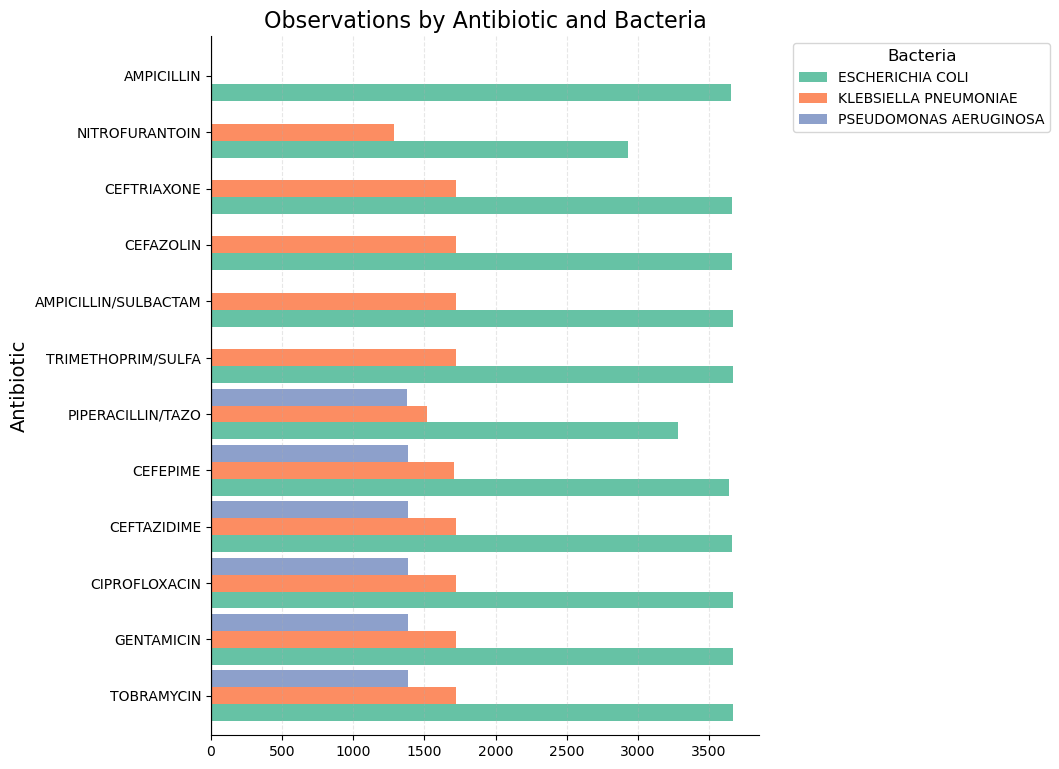

In [88]:
# Count the occurrences of each organism-antibiotic combination
count_df = obs.groupby(['org_name', 'ab_name']).size().reset_index(name='count')
total_counts = count_df.groupby('ab_name')['count'].sum().reset_index()
total_counts = total_counts.sort_values('count', ascending=False)

sorted_antibiotics = total_counts['ab_name'].tolist()

# Pivot the data to have organisms as columns and antibiotics as rows
pivot_df = count_df.pivot(index='ab_name', columns='org_name', values='count')

# Fill NaN values with 0
pivot_df = pivot_df.fillna(0)

# Reorder the rows based on the total counts
pivot_df = pivot_df.reindex(sorted_antibiotics)

# Using a colorful palette like 'tab10', 'tab20', or 'Set3'
color_palette = sns.color_palette("Set2", len(pivot_df.index))

# Set larger font sizes globally
plt.rcParams.update({
    'font.size': 14,           # Base font size
    'axes.titlesize': 18,      # Title font size
    'axes.labelsize': 16,      # Axis label font size
    'xtick.labelsize': 16,     # X-axis tick labels
    'ytick.labelsize': 16,     # Y-axis tick labels
    'legend.fontsize': 10,     # Legend font size
    'legend.title_fontsize': 12  # Legend title font size
})

# Set up the plot
plt.figure(figsize=(14, 10))
ax = pivot_df.plot(kind='barh', figsize=(12, 8), color=color_palette, width=0.9)

# Add labels and title
#plt.xlabel('# of Observations', fontsize=12)
plt.ylabel('Antibiotic', fontsize=14)
plt.title('Observations by Antibiotic and Bacteria', fontsize=16)

# Add a legend with a better position
plt.legend(title='Bacteria', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve spacing
plt.tight_layout()

# Style improvements
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='black', linewidth=0.8)  # Add vertical line at x=0
plt.gca().spines['top'].set_visible(False)      # Remove top border
plt.gca().spines['right'].set_visible(False)    # Remove right border
plt.tick_params(axis='both', which='major', labelsize=10)  # Adjust tick label size

# Add grid lines for better readability
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a total count column for reference
pivot_df['Total'] = pivot_df.sum(axis=1)

# Sort organisms by their total counts
organism_totals = count_df.groupby('org_name')['count'].sum().sort_values(ascending=False)
sorted_organisms = organism_totals.index.tolist()

# Reorganize columns to put them in descending order of total count (excluding the Total column)
cols_to_sort = [col for col in pivot_df.columns if col != 'Total']
sorted_cols = sorted(cols_to_sort, key=lambda x: organism_totals.get(x, 0), reverse=True) + ['Total']
pivot_df = pivot_df[sorted_cols]

# Show the plot
plt.show()

# Racial Fairness 

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from scipy.stats import chi2_contingency

In [90]:
with open('output/histxgb_models_stratification_2025-04-06_21-46-09.pkl', 'rb') as file:
    trained_models = pickle.load(file)

In [91]:
def test_model_fairness(trained_models, modeling_df, race_columns, output_metrics=True, visualize=True):
    """
    Test XGBoost models for racial bias across all bacteria-antibiotic pairs.
    
    Parameters:
    -----------
    trained_models : dict
        Dictionary of trained XGBoost models with keys as 'bacteria_antibiotic' pairs
    modeling_df : pandas.DataFrame
        DataFrame containing features and target variables
    race_columns : list
        List of column names that represent one-hot encoded race variables
    output_metrics : bool, default=True
        Whether to print detailed metrics
    visualize : bool, default=True
        Whether to create visualizations
        
    Returns:
    --------
    dict
        Dictionary with fairness metrics for each model
    """
    # Create a dictionary to store fairness metrics
    fairness_results = {}
    
    # Identify all unique races from the race columns
    races = [col.replace('broad_race_', '') for col in race_columns]
    
    # Iterate through each model
    for model_name, model in trained_models.items():
        print(f"\n{'='*50}")
        print(f"Testing model: {model_name}")
        print(f"{'='*50}")
        
        # Extract bacteria and antibiotic from the model name
        bacteria, antibiotic = model_name.split('_', 2)[1:]

        # fitler data 
        modeling_df = modeling_df[(modeling_df['org_name'] == bacteria) & (modeling_df['ab_name'] == antibiotic)]

        target_col = "susceptible_flag" 
        feature_cols = modeling_df.columns[5:]

    # Initialize race-specific metrics
        race_metrics = {}
        
        # Create figures for visualizations if requested
        if visualize:
            fig_roc, ax_roc = plt.subplots(figsize=(10, 6))
            
        # Test model performance for each race
        for i, race in enumerate(races):
            race_col = f"broad_race_{race}"
            
            # Skip if this race column doesn't exist
            if race_col not in modeling_df.columns:
                continue
                
            # Get subset of data for this race
            race_data = modeling_df[modeling_df[race_col] == 1]
            
            # Skip if not enough samples for this race
            if len(race_data) < 20:  # Arbitrary threshold, adjust as needed
                print(f"Too few samples for {race} (n={len(race_data)}). Skipping...")
                continue
                
            # Get features and target for this race
            X_race = race_data[feature_cols]
            y_race = race_data[target_col]
            
            # Make predictions
            y_pred_proba = model.predict_proba(X_race)[:, 1]
            y_pred = model.predict(X_race)
            
            # Calculate metrics
            auc = roc_auc_score(y_race, y_pred_proba)
            accuracy = (y_pred == y_race).mean()
            cm = confusion_matrix(y_race, y_pred, normalize='true')
            
            # Store metrics
            race_metrics[race] = {
                'count': len(race_data),
                'resistance_rate': y_race.mean(),
                'auc': auc,
                'accuracy': accuracy,
                'specificity': cm[0, 0],  # True negative rate
                'sensitivity': cm[1, 1],  # True positive rate
                'false_pos_rate': cm[0, 1],  # False positive rate
                'false_neg_rate': cm[1, 0],  # False negative rate
                'predictions': y_pred,
                'true_values': y_race
            }
            
            # Print metrics if requested
            if output_metrics:
                print(f"\n--- {race} (n={len(race_data)}) ---")
                print(f"Resistance Rate: {y_race.mean():.4f}")
                print(f"AUC: {auc:.4f}")
                print(f"Accuracy: {accuracy:.4f}")
                print(f"Specificity: {cm[0, 0]:.4f}")
                print(f"Sensitivity: {cm[1, 1]:.4f}")
                print(f"False Positive Rate: {cm[0, 1]:.4f}")
                print(f"False Negative Rate: {cm[1, 0]:.4f}")
                
            # Add to ROC curve plot if visualizing
            if visualize:
                ax_roc.plot([0, 1], [0, 1], 'k--')
                ax_roc.plot([cm[0, 1]], [cm[1, 1]], 'o', label=f"{race} (AUC={auc:.3f})")
        
        # Calculate disparity metrics across races
        if len(race_metrics) >= 2:
            # Get metrics for the reference race (using largest group as reference)
            ref_race = max(race_metrics.items(), key=lambda x: x[1]['count'])[0]
            ref_metrics = race_metrics[ref_race]
            
            # Calculate disparities relative to reference race
            disparities = {}
            for race, metrics in race_metrics.items():
                if race != ref_race:
                    disparities[race] = {
                        'auc_ratio': metrics['auc'] / ref_metrics['auc'],
                        'specificity_ratio': metrics['specificity'] / ref_metrics['specificity'],
                        'sensitivity_ratio': metrics['sensitivity'] / ref_metrics['sensitivity'],
                        'fpr_ratio': metrics['false_pos_rate'] / ref_metrics['false_pos_rate'] if ref_metrics['false_pos_rate'] > 0 else float('inf'),
                        'fnr_ratio': metrics['false_neg_rate'] / ref_metrics['false_neg_rate'] if ref_metrics['false_neg_rate'] > 0 else float('inf'),
                    }
            
            # Print disparity metrics if requested
            if output_metrics:
                print(f"\n--- Disparity Metrics (Reference: {ref_race}) ---")
                for race, disp in disparities.items():
                    print(f"\n{race} vs {ref_race}:")
                    print(f"AUC Ratio: {disp['auc_ratio']:.4f}")
                    print(f"Specificity Ratio: {disp['specificity_ratio']:.4f}")
                    print(f"Sensitivity Ratio: {disp['sensitivity_ratio']:.4f}")
                    print(f"False Positive Rate Ratio: {disp['fpr_ratio']:.4f}")
                    print(f"False Negative Rate Ratio: {disp['fnr_ratio']:.4f}")
            
            # Statistical test for significant differences in accuracy across races
            contingency_tables = {}
            for race, metrics in race_metrics.items():
                # Create contingency table of correct/incorrect predictions
                correct = (metrics['predictions'] == metrics['true_values']).sum()
                incorrect = len(metrics['predictions']) - correct
                contingency_tables[race] = [correct, incorrect]
            
            # Convert to numpy array for chi-square test
            contingency_array = np.array(list(contingency_tables.values()))
            
            # Perform chi-square test if we have at least 2 races
            if len(contingency_array) >= 2:
                chi2, p_value, _, _ = chi2_contingency(contingency_array)
                if output_metrics:
                    print(f"\n--- Statistical Test for Accuracy Differences ---")
                    print(f"Chi-squared: {chi2:.4f}")
                    print(f"p-value: {p_value:.4f}")
                    print(f"Statistically significant difference: {p_value < 0.05}")
            
            # Store disparity results
            race_metrics['disparities'] = disparities
            race_metrics['chi2_test'] = {'chi2': chi2, 'p_value': p_value}
        
        # Finalize visualizations if requested
        if visualize and len(race_metrics) >= 2:
            ax_roc.set_xlabel('False Positive Rate')
            ax_roc.set_ylabel('True Positive Rate')
            ax_roc.set_title(f'ROC Points by Race for {model_name}')
            ax_roc.legend()
            plt.tight_layout()
            plt.show()
            
            # Create additional fairness visualizations
            metrics_to_plot = ['auc', 'specificity', 'sensitivity', 'false_pos_rate', 'false_neg_rate']
            fig_fairness, axes_fairness = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4*len(metrics_to_plot)))
            
            for i, metric in enumerate(metrics_to_plot):
                metric_values = {race: metrics[metric] for race, metrics in race_metrics.items() if race not in ['disparities', 'chi2_test']}
                if metric_values:
                    sns.barplot(x=list(metric_values.keys()), y=list(metric_values.values()), ax=axes_fairness[i])
                    axes_fairness[i].set_title(f'{metric.replace("_", " ").title()} by Race')
                    axes_fairness[i].set_ylim(0, 1)
                    plt.setp(axes_fairness[i].get_xticklabels(), rotation=45, ha='right')
            
            fig_fairness.tight_layout()
            plt.show()
        
        # Store all metrics for this model
        fairness_results[model_name] = race_metrics

        return fairness_results

In [14]:
def generate_fairness_report(fairness_results, threshold=0.2):
    """
    Generate a summary report highlighting potential bias issues.
    
    Parameters:
    -----------
    fairness_results : dict
        Dictionary with fairness metrics for each model
    threshold : float, default=0.2
        Threshold for flagging disparities (e.g., 0.2 means 20% difference)
        
    Returns:
    --------
    dict
        Dictionary with summary of bias issues
    """
    report = {}
    
    for model_name, race_metrics in fairness_results.items():
        model_issues = []
        
        # Skip if no disparity metrics
        if 'disparities' not in race_metrics:
            continue
            
        disparities = race_metrics['disparities']
        
        # Check for significant p-value in chi-squared test
        if 'chi2_test' in race_metrics and race_metrics['chi2_test']['p_value'] < 0.05:
            model_issues.append(f"Statistically significant differences in accuracy across races (p={race_metrics['chi2_test']['p_value']:.4f})")
        
        # Check metrics with large disparities
        for race, disp in disparities.items():
            for metric, ratio in disp.items():
                # Flag if ratio is too high or too low
                if ratio < (1 - threshold) or ratio > (1 + threshold):
                    # Translate metric name to more readable form
                    metric_name = metric.replace('_ratio', '').replace('_', ' ').title()
                    
                    # Determine direction of disparity
                    direction = "lower" if ratio < 1 else "higher"
                    percent_diff = abs(1 - ratio) * 100
                    
                    model_issues.append(f"{race} has {percent_diff:.1f}% {direction} {metric_name} than the reference group")
        
        if model_issues:
            report[model_name] = model_issues
    
    return report

In [92]:
# Extract bacteria and antibiotic from the model name
bacteria, antibiotic = ('ESCHERICHIA COLI', 'AMPICILLIN')

        # fitler data 
modeling_df = modeling_df[(modeling_df['org_name'] == bacteria) & (modeling_df['ab_name'] == antibiotic)]

target_col = "susceptible_flag" 
feature_cols = modeling_df.columns[5:]

race_col = 'broad_race_White'
race_data = modeling_df[modeling_df[race_col] == 1]
            

            # Get features and target for this race
X_race = race_data[feature_cols]
y_race = race_data[target_col]


Testing model: rf_ESCHERICHIA COLI_AMPICILLIN

--- Hispanic/Latino (n=227) ---
Resistance Rate: 0.4009
AUC: 0.7951
Accuracy: 0.7137
Specificity: 0.8088
Sensitivity: 0.5714
False Positive Rate: 0.1912
False Negative Rate: 0.4286

--- White (n=2530) ---
Resistance Rate: 0.4190
AUC: 0.8065
Accuracy: 0.7332
Specificity: 0.8469
Sensitivity: 0.5755
False Positive Rate: 0.1531
False Negative Rate: 0.4245

--- Asian (n=117) ---
Resistance Rate: 0.3248
AUC: 0.8191
Accuracy: 0.7436
Specificity: 0.8608
Sensitivity: 0.5000
False Positive Rate: 0.1392
False Negative Rate: 0.5000

--- Other/Unknown (n=154) ---
Resistance Rate: 0.3571
AUC: 0.8149
Accuracy: 0.7532
Specificity: 0.8283
Sensitivity: 0.6182
False Positive Rate: 0.1717
False Negative Rate: 0.3818

--- Black (n=607) ---
Resistance Rate: 0.4201
AUC: 0.8311
Accuracy: 0.7496
Specificity: 0.8551
Sensitivity: 0.6039
False Positive Rate: 0.1449
False Negative Rate: 0.3961

--- Disparity Metrics (Reference: White) ---

Hispanic/Latino vs White:
A

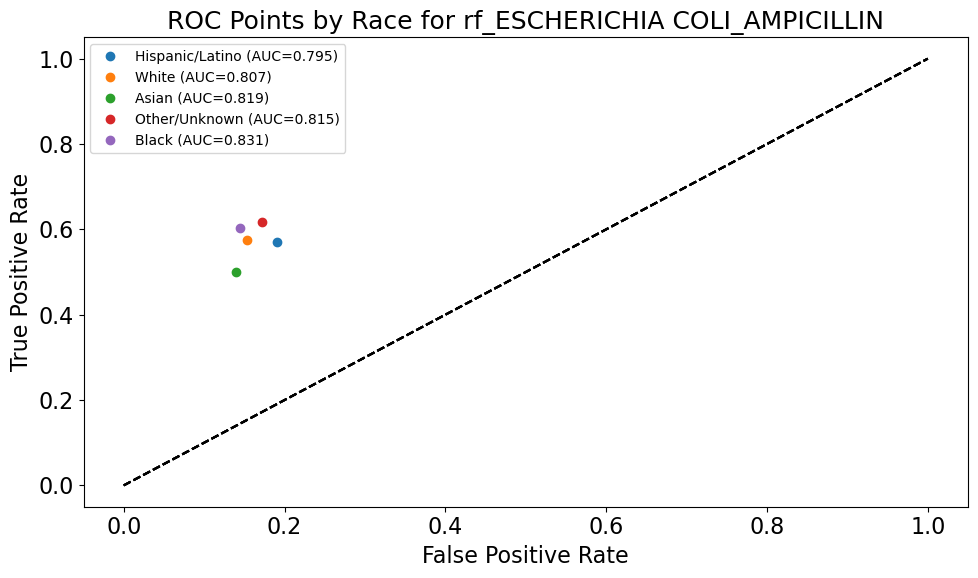

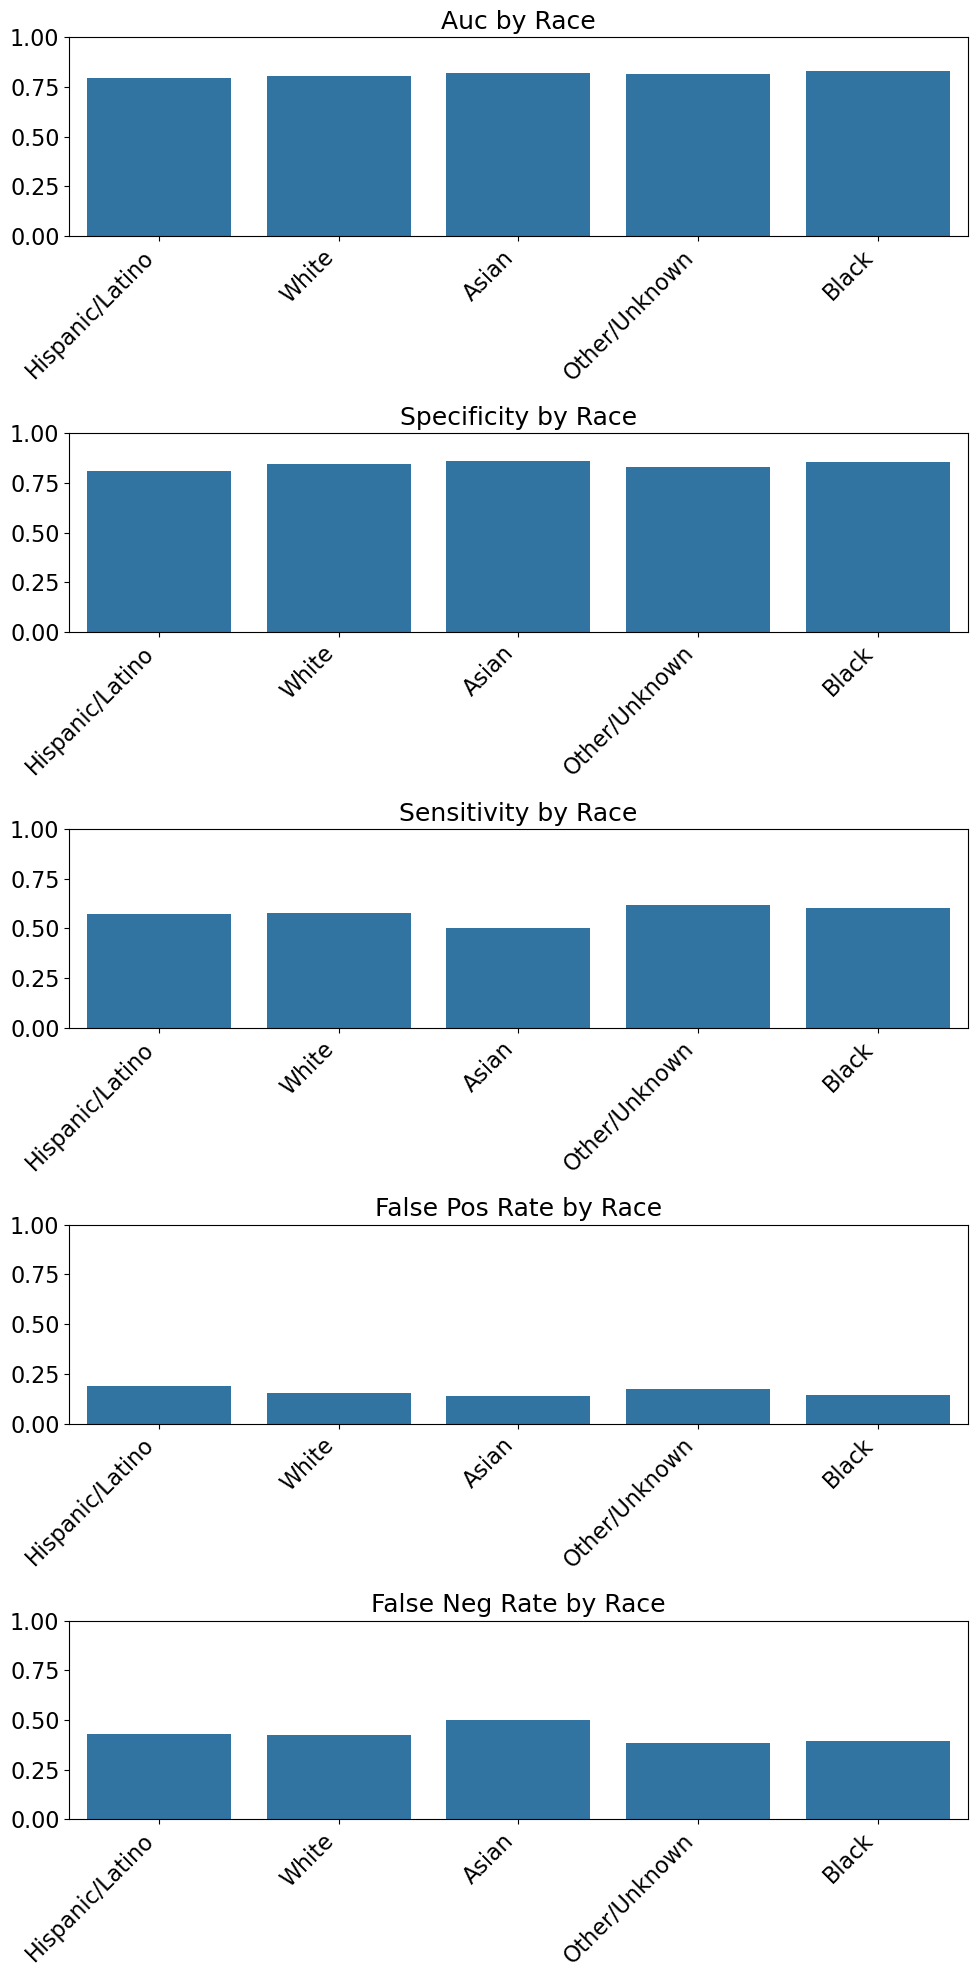

In [95]:
modeling_df = modeling_df.drop(columns=['race_category', 'to_stratify'])

# First, identify race columns
race_columns = [col for col in modeling_df.columns if col.startswith('broad_race_')]

# Test all models
fairness_results = test_model_fairness(trained_models, modeling_df, race_columns)

In [96]:
# Generate summary report
bias_report = generate_fairness_report(fairness_results)

# Print summary of models with potential bias issues
print("\n\n=== SUMMARY OF POTENTIAL BIAS ISSUES ===")
if bias_report:
    for model_name, issues in bias_report.items():
        print(f"\n{model_name}:")
        for issue in issues:
            print(f"  - {issue}")
else:
    print("No significant bias issues detected.")



=== SUMMARY OF POTENTIAL BIAS ISSUES ===

rf_ESCHERICHIA COLI_AMPICILLIN:
  - Hispanic/Latino has 24.9% higher Fpr than the reference group


- Consider retraining models using a stratified data set to balance for race 

# Doctor's Prescription vs. Model Output

In [97]:
file_name = 'MIMIC/Cleaned/df_final_antibiotic_prescribed.csv'
prescribed_ab = from_s3(bucket_name, file_name) 
prescribed_ab.head()

,subject_id,charttime,medication,hours_to_prescribe,ab_name_pr
0,10000826,2146-12-08 22:22:00,Ciprofloxacin HCl,11.161944,CIPROFLOXACIN
1,10001401,2134-10-09 13:45:00,CefePIME,3.163611,CEFEPIME
2,10002013,2165-11-23 06:38:00,CefePIME,13.546389,CEFEPIME
3,10002114,2162-02-17 21:53:00,CefTRIAXone,2.186944,CEFTRIAXONE
4,10002131,2128-03-17 00:00:00,CeftriaXONE,34.376389,CEFTRIAXONE


In [108]:
eval_df = pd.merge(prescribed_ab, modeling_df, on=['subject_id', 'charttime'], how='inner')
eval_df = eval_df.query("org_name in ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA']")
#eval_df = eval_df.query("ab_name != 'MEROPENEM'")
eval_df.head()

,subject_id,charttime,medication,hours_to_prescribe,ab_name_pr,org_name,ab_name,susceptible_flag,Blood - Hematocrit,Blood - Platelet Count,Blood - MCV,Blood - Red Blood Cells,Blood - RDW,Blood - MCH,Blood - MCHC,Blood - White Blood Cells,Blood - Creatinine,Blood - Urea Nitrogen,Blood - Potassium,Blood - Sodium,Blood - Chloride,Blood - Bicarbonate,Blood - Anion Gap,Blood - Hemoglobin,Blood - Basophils,Blood - Lymphocytes,Blood - Eosinophils,"Blood - Calcium, Total",Blood - Alanine Aminotransferase (ALT),Blood - Asparate Aminotransferase (AST),Blood - Magnesium,Blood - Phosphate,Blood - INR(PT),Blood - PT,Blood - Alkaline Phosphatase,"Blood - Bilirubin, Total",Blood - Neutrophils,Blood - PTT,Urine - Specific Gravity,Urine - pH,anchor_age,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,procedure_ct,days_since_last_proc,Blood - Glucose,Blood - Monocytes,Urine - Urine Color,Urine - Urine Appearance,Urine - Ketone,Urine - Glucose,Urine - Protein,Urine - Epithelial Cells,Urine - RBC,Urine - WBC,99,BLD001,BLD002,BLD003,BLD004,BLD005,BLD006,BLD007,BLD008,BLD009,BLD010,CIR001,CIR002,CIR003,CIR004,CIR005,CIR006,CIR007,CIR008,CIR009,CIR010,CIR011,CIR012,CIR013,CIR014,CIR015,CIR016,CIR017,CIR018,CIR019,CIR020,CIR021,CIR022,CIR023,CIR024,CIR025,CIR026,CIR027,CIR028,CIR029,CIR030,CIR031,CIR032,CIR033,CIR034,CIR035,CIR036,CIR037,CIR038,CIR039,DEN001,DEN002,DEN003,DIG001,DIG002,DIG003,DIG004,DIG005,DIG006,DIG007,DIG008,DIG009,DIG010,DIG011,DIG012,DIG013,DIG014,DIG015,DIG016,DIG017,DIG018,DIG019,DIG020,DIG021,DIG022,DIG023,DIG024,DIG025,EAR001,EAR002,EAR003,EAR004,EAR005,EAR006,END001,END002,END003,END004,END005,END006,END007,END008,END009,END010,END011,END012,END013,END014,END015,END016,END017,EXT001,EXT002,EXT003,EXT004,EXT005,EXT006,EXT007,EXT008,EXT009,EXT010,EXT011,EXT012,EXT013,EXT014,EXT015,EXT016,EXT017,EXT018,EXT019,EXT020,EXT021,EXT022,EXT023,EXT024,EXT025,EXT026,EXT027,EXT028,EXT029,EXT030,EYE001,EYE002,EYE003,EYE004,EYE005,EYE006,EYE007,EYE008,EYE009,EYE010,EYE011,EYE012,FAC001,FAC002,FAC003,FAC004,FAC005,FAC006,FAC008,FAC009,FAC010,FAC012,FAC013,FAC014,FAC015,FAC016,FAC017,FAC019,FAC020,FAC022,FAC023,FAC024,FAC025,FAC026,FAC027,FAC028,FAC029,FAC030,GEN001,GEN002,GEN003,GEN004,GEN005,GEN006,GEN007,GEN008,GEN009,GEN010,GEN011,GEN012,GEN013,GEN014,GEN015,GEN016,GEN017,GEN018,GEN019,GEN020,GEN021,GEN022,GEN023,GEN024,GEN025,GEN026,INF001,INF002,INF003,INF004,INF005,INF006,INF007,INF008,INF009,INF010,INF011,INF012,INJ001,INJ002,INJ003,INJ004,INJ005,INJ006,INJ007,INJ008,INJ009,INJ010,INJ011,INJ012,INJ013,INJ014,INJ015,INJ016,INJ017,INJ018,INJ019,INJ020,INJ021,INJ022,INJ023,INJ024,INJ025,INJ026,INJ027,INJ028,INJ029,INJ030,INJ031,INJ032,INJ033,INJ034,INJ035,INJ036,INJ037,INJ038,INJ039,INJ040,INJ041,INJ042,INJ043,INJ044,INJ045,INJ046,INJ047,INJ048,INJ049,INJ050,INJ054,INJ055,INJ056,INJ057,INJ059,INJ060,INJ061,INJ062,INJ063,INJ064,INJ065,INJ066,INJ067,INJ069,INJ070,INJ071,INJ072,INJ073,INJ074,INJ075,INJ076,MAL001,MAL002,MAL003,MAL004,MAL005,MAL006,MAL007,MAL008,MAL009,MAL010,MBD001,MBD002,MBD003,MBD004,MBD005,MBD006,MBD007,MBD008,MBD009,MBD010,MBD011,MBD012,MBD013,MBD014,MBD017,MBD018,MBD019,MBD020,MBD021,MBD022,MBD023,MBD024,MBD025,MBD026,MBD027,MBD028,MBD032,MBD034,MUS001,MUS002,MUS003,MUS004,MUS005,MUS006,MUS007,MUS008,MUS009,MUS010,MUS011,MUS012,MUS013,MUS014,MUS015,MUS016,MUS017,MUS020,MUS021,MUS022,MUS023,MUS024,MUS025,MUS026,MUS027,MUS028,MUS029,MUS030,MUS031,MUS032,MUS033,MUS034,MUS035,MUS036,MUS037,MUS038,NEO001,NEO002,NEO003,NEO004,NEO005,NEO006,NEO007,NEO008,NEO009,NEO010,NEO011,NEO012,NEO013,NEO014,NEO015,NEO016,NEO017,NEO018,NEO019,NEO020,NEO021,NEO022,NEO023,NEO024,NEO025,NEO026,NEO027,NEO028,NEO029,NEO030,NEO031,NEO032,NEO033,NEO034,NEO035,NEO036,NEO037,NEO038,NEO039,NEO040,NEO041,NEO042,NEO043,NEO044,NEO045,NEO046,NEO047,NEO048,NEO049,NEO050,NEO051,NEO052,NEO054,NEO056,NEO057,NEO058,NEO059,NEO060,NEO061,NEO062,NEO063,NEO064,NEO065,NEO066,NEO067,NEO068,NEO069,NEO070,NEO071,NEO072,NEO073,NEO074,NEO075,NEO078,NVS001,NVS002

In [110]:
tiers = [('ESCHERICHIA COLI', 'AMPICILLIN', 'other', 'narrow'),
 ('ESCHERICHIA COLI', 'AMPICILLIN/SULBACTAM', 'second', 'moderate'),
 ('ESCHERICHIA COLI', 'CEFAZOLIN', 'second', 'narrow'),
 ('ESCHERICHIA COLI', 'CEFEPIME', 'second', 'broad'),
 ('ESCHERICHIA COLI', 'CEFTAZIDIME', 'second', 'broad'),
 ('ESCHERICHIA COLI', 'CEFTRIAXONE', 'first', 'broad'),
 ('ESCHERICHIA COLI', 'CIPROFLOXACIN', 'second', 'broad'),
 ('ESCHERICHIA COLI', 'GENTAMICIN', 'other', 'moderate'),
 ('ESCHERICHIA COLI', 'MEROPENEM', 'last', 'broad'),
 ('ESCHERICHIA COLI', 'NITROFURANTOIN', 'first', 'narrow'),
 ('ESCHERICHIA COLI', 'PIPERACILLIN/TAZO', 'second', 'broad'),
 ('ESCHERICHIA COLI', 'TOBRAMYCIN', 'other', 'moderate'),
 ('ESCHERICHIA COLI', 'TRIMETHOPRIM/SULFA', 'first', 'moderate'),
 ('KLEBSIELLA PNEUMONIAE', 'AMPICILLIN/SULBACTAM', 'second', 'moderate'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFAZOLIN', 'other', 'narrow'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFEPIME', 'first', 'broad'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFTAZIDIME', 'second', 'broad'),
 ('KLEBSIELLA PNEUMONIAE', 'CEFTRIAXONE', 'first', 'broad'),
 ('KLEBSIELLA PNEUMONIAE', 'CIPROFLOXACIN', 'second', 'broad'),
 ('KLEBSIELLA PNEUMONIAE', 'GENTAMICIN', 'second', 'moderate'),
 ('KLEBSIELLA PNEUMONIAE', 'MEROPENEM', 'last', 'broad'),
 ('KLEBSIELLA PNEUMONIAE', 'NITROFURANTOIN', 'first', 'narrow'),
 ('KLEBSIELLA PNEUMONIAE', 'PIPERACILLIN/TAZO', 'first', 'broad'),
 ('KLEBSIELLA PNEUMONIAE', 'TOBRAMYCIN', 'second', 'moderate'),
 ('KLEBSIELLA PNEUMONIAE', 'TRIMETHOPRIM/SULFA', 'first', 'moderate'),
 ('PSEUDOMONAS AERUGINOSA', 'CEFEPIME', 'first', 'broad'),
 ('PSEUDOMONAS AERUGINOSA', 'CEFTAZIDIME', 'first', 'moderate'),
 ('PSEUDOMONAS AERUGINOSA', 'CIPROFLOXACIN', 'second', 'moderate'),
 ('PSEUDOMONAS AERUGINOSA', 'GENTAMICIN', 'second', 'narrow'),
 ('PSEUDOMONAS AERUGINOSA', 'MEROPENEM', 'last', 'broad'),
 ('PSEUDOMONAS AERUGINOSA', 'PIPERACILLIN/TAZO', 'first', 'broad'),
 ('PSEUDOMONAS AERUGINOSA', 'TOBRAMYCIN', 'other', 'narrow')]

tiers = pd.DataFrame(tiers, columns=['org_name', 'ab_name', 'tier', 'spectrum'])
tiers.head()

,org_name,ab_name,tier,spectrum
0,ESCHERICHIA COLI,AMPICILLIN,other,narrow
1,ESCHERICHIA COLI,AMPICILLIN/SULBACTAM,second,moderate
2,ESCHERICHIA COLI,CEFAZOLIN,second,narrow
3,ESCHERICHIA COLI,CEFEPIME,second,broad
4,ESCHERICHIA COLI,CEFTAZIDIME,second,broad


## Final Antibiotic Evaluation

In [109]:
# predict for each patient 
results = pd.DataFrame()

for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df)):
    org = row['org_name']
    ab = row['ab_name']
    
    model_name = f"rf_{org}_{ab}"
    model = trained_models[model_name]

    X = pd.DataFrame(row[8:]).T

    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    to_add = pd.DataFrame({'subject_id': row['subject_id'], 'charttime': row['charttime'], 'org_name':org, 
              'ab_name':ab, 'actual':row['susceptible_flag'], 'prediction':y_pred, 'susceptability':y_pred_proba,
              'ab_prescribed':row['ab_name_pr'], 'hours_to_prescribe':row['hours_to_prescribe']})

    results = pd.concat([results, to_add], ignore_index=True)

results = results.merge(tiers, on=['org_name', 'ab_name'], how='left')
results = results.merge(tiers.add_suffix('_prescribed'), left_on=['org_name', 'ab_prescribed'], right_on = ['org_name_prescribed', 'ab_name_prescribed'], how='left')
results.drop(['org_name_prescribed', 'ab_name_prescribed'], axis=1, inplace=True)

100%|██████████| 3110/3110 [00:25<00:00, 119.66it/s]


In [111]:
results.head()

,subject_id,charttime,org_name,ab_name,actual,prediction,susceptability,ab_prescribed,hours_to_prescribe,tier,spectrum,tier_prescribed,spectrum_prescribed
0,10011938,2133-12-27 05:21:00,ESCHERICHIA COLI,AMPICILLIN,0.0,0.0,0.315844,PIPERACILLIN/TAZO,8.345278,other,narrow,second,broad
1,10014610,2169-01-29 17:50:00,ESCHERICHIA COLI,AMPICILLIN,1.0,0.0,0.386809,PIPERACILLIN/TAZO,51.639444,other,narrow,second,broad
2,10017886,2141-04-29 14:47:00,ESCHERICHIA COLI,AMPICILLIN,0.0,0.0,0.368978,CEFTRIAXONE,68.778889,other,narrow,first,broad
3,10017886,2141-04-29 14:47:00,ESCHERICHIA COLI,AMPICILLIN,0.0,0.0,0.368978,TRIMETHOPRIM/SULFA,20.892778,other,narrow,first,moderate
4,10019517,2166-01-23 14:24:00,ESCHERICHIA COLI,AMPICILLIN,1.0,1.0,0.642046,CEFTRIAXONE,2.638611,other,narrow,first,broad


In [119]:
# Proportion of antibiotics prescribed that were actually resistant
prop = results.query("ab_name == ab_prescribed")
prop_resistant = np.round(1 - (prop.actual.sum() / len(prop.actual)), 2)
print(f"{prop_resistant * 100}% of prescriptions were actually resistant to the bacteria")

# model would have correctly identified how many of these
prop = prop.query("actual == 0")
prop_correct = np.round(1 - (prop.prediction.sum() / len(prop.actual)), 2)
print(f"Our model would have correctly identified {prop_correct * 100}% of these as resistant")

44.0% of prescriptions were actually resistant to the bacteria
Our model would have correctly identified 71.0% of these as resistant


In [122]:
# % of cases where there was at least one susceptible antibiotic in tier 1 but a doctor used an antbiotic from a lower tier 
first_tier_avail = results.query("tier == 'first' and actual == 1 and tier_prescribed != 'first'")
prop_lower_tier = np.round(first_tier_avail[['subject_id', 'charttime']].drop_duplicates().shape[0] / (results[['subject_id', 'charttime']].drop_duplicates().shape[0]+1), 2)
print(f"In {np.round(prop_lower_tier * 100, 2)}% of cases physicians prescribed a lower tier antibiotic when there was a first tier susceptible antibiotic available")

# model would have identified 
model_correct = first_tier_avail.query("prediction == 1")
prop_correct = np.round(model_correct[['subject_id', 'charttime']].drop_duplicates().shape[0] / (first_tier_avail[['subject_id', 'charttime']].drop_duplicates().shape[0]+1), 3)
print(f"Our model would have identified a first tier susceptible antibiotic in {prop_correct * 100}% of these cases")

In 0.0% of cases physicians prescribed a lower tier antibiotic when there was a first tier susceptible antibiotic available
Our model would have identified a first tier susceptible antibiotic in 0.0% of these cases


In [124]:
# % of cases where doctor prescribed broad when narrow was available (first tier only) 
first_tier_not_broad = results.query("tier == 'first' and spectrum != 'broad' and actual == 1")
prescribed_broad = first_tier_not_broad.query("spectrum_prescribed == 'broad'")
prop_broad = np.round(prescribed_broad[['subject_id', 'charttime']].drop_duplicates().shape[0] / first_tier_not_broad[['subject_id', 'charttime']].drop_duplicates().shape[0], 2)
print(f"In {np.round(prop_broad * 100, 2)}% of cases physicians prescribed a broad spectrum when there was a first tier moderate / narrow spectrum available")

# model would have... 
model_correct = prescribed_broad.query("prediction == 1")
prop_correct = np.round(model_correct[['subject_id', 'charttime']].drop_duplicates().shape[0] / prescribed_broad[['subject_id', 'charttime']].drop_duplicates().shape[0], 2)
print(f"Our model would have identified a first tier moderate / narrow susceptible antibiotic in {prop_correct * 100}% of these cases")

ZeroDivisionError: division by zero

### Average Time to Prescibe per Bacteria 

In [76]:
eval_time = eval_df[['org_name', 'hours_to_prescribe']].drop_duplicates()
eval_time.head()

,org_name,hours_to_prescribe
0,PSEUDOMONAS AERUGINOSA,67.025000
7,PSEUDOMONAS AERUGINOSA,69.890833
14,PSEUDOMONAS AERUGINOSA,1.916111
21,KLEBSIELLA PNEUMONIAE,22.752778
32,KLEBSIELLA PNEUMONIAE,3.800833


In [71]:
def plot_times(df):
    organism_order = df.groupby('org_name')['hours_to_prescribe'].median().sort_values().index
    
    # Set figure size based on number of organisms
    plt.figure(figsize=(12, max(8, len(organism_order) * 0.4)))
    
    # Create the boxplot
    ax = sns.boxplot(
        x='hours_to_prescribe', 
        y='org_name', 
        data=df,
        order=organism_order,
        palette='viridis',
        orient='h',
        width=0.6
    )
    
    # Add a swarm plot to show individual data points (optional, can be commented out for large datasets)
    sns.stripplot(
        x='hours_to_prescribe', 
        y='org_name', 
        data=df,
        order=organism_order,
        color='black',
        size=3,
        alpha=0.3,
        jitter=True,
        orient='h'
    )
    
    # Calculate and add mean markers
    for i, org in enumerate(organism_order):
        mean_val = df[df['org_name'] == org]['hours_to_prescribe'].mean()
        plt.plot(mean_val, i, marker='D', color='red', markersize=6)
    
    # Add count of samples for each organism
    counts = df.groupby('org_name').size()
    for i, org in enumerate(organism_order):
        plt.text(
            ax.get_xlim()[1] * 1.01,  # Place text just outside the right edge of the plot
            i,                         # y-coordinate (matching the organism position)
            f"n={counts[org]}",        # Text to display
            va='center'                # Vertical alignment
        )
    
    # Set labels and title
    plt.xlabel('Hours to Prescribe')
    plt.ylabel('Organism')
    plt.title('Distribution of Hours to Prescribe by Organism')
    
    # Add a grid for easier reading
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('hours_to_prescribe_distribution.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

/tmp/ipykernel_363/3725440375.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


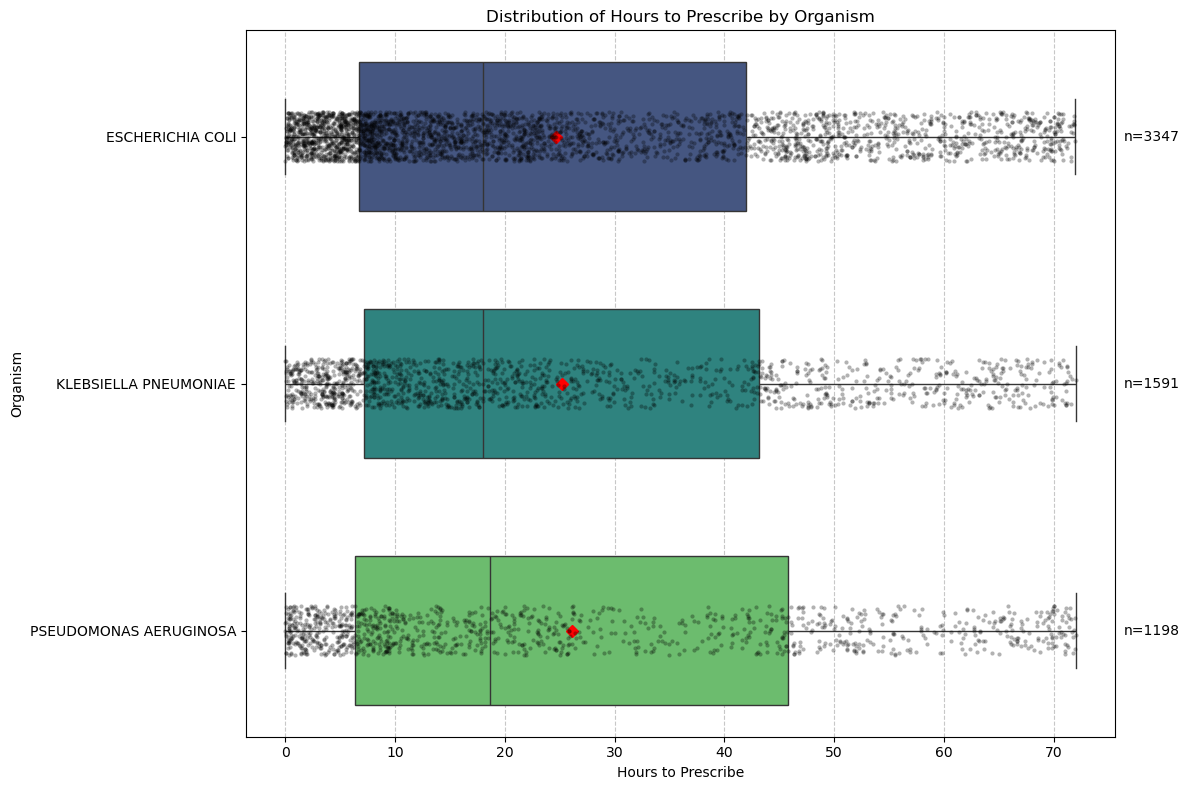

In [77]:
plot_times(eval_time)